In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

# Import necessary libraries
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, AveragePooling2D, Flatten, Dense, Dropout, concatenate, GlobalAveragePooling2D
import keras
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Conv2D, MaxPooling2D,
    AveragePooling2D, GlobalAveragePooling2D, Flatten,
    BatchNormalization, Activation, Concatenate
)


In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, Concatenate, BatchNormalization
)
from sklearn.preprocessing import LabelEncoder


source_folder = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/source_folder"
train_dir = os.path.join(source_folder, "train")
test_dir = os.path.join(source_folder, "test")


IMG_SIZE = (224, 224)
BATCH_SIZE = 32


base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)  # Features from block5_pool
vgg19_model.trainable = False


def load_data(directory):
    data = []
    labels = []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                data.append(img_array)
                labels.append(label)
    return np.array(data), np.array(labels)


train_data, train_labels = load_data(train_dir)
test_data, test_labels = load_data(test_dir)


label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)


train_features = vgg19_model.predict(train_data, batch_size=BATCH_SIZE, verbose=1)
test_features = vgg19_model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)


train_features = train_features.reshape(-1, train_features.shape[1], train_features.shape[2], train_features.shape[3])
test_features = test_features.reshape(-1, test_features.shape[1], test_features.shape[2], test_features.shape[3])


def build_inception_v3_scratch(input_shape):
    input_layer = Input(shape=input_shape)


    branch1x1 = Conv2D(64, (1, 1), padding="same", activation="relu")(input_layer)
    branch1x1 = BatchNormalization()(branch1x1)

    branch3x3 = Conv2D(64, (1, 1), padding="same", activation="relu")(input_layer)
    branch3x3 = BatchNormalization()(branch3x3)
    branch3x3 = Conv2D(64, (3, 3), padding="same", activation="relu")(branch3x3)
    branch3x3 = BatchNormalization()(branch3x3)

    branch5x5 = Conv2D(32, (1, 1), padding="same", activation="relu")(input_layer)
    branch5x5 = BatchNormalization()(branch5x5)
    branch5x5 = Conv2D(32, (5, 5), padding="same", activation="relu")(branch5x5)
    branch5x5 = BatchNormalization()(branch5x5)

    branch_pool = MaxPooling2D((3, 3), strides=(1, 1), padding="same")(input_layer)
    branch_pool = Conv2D(32, (1, 1), padding="same", activation="relu")(branch_pool)
    branch_pool = BatchNormalization()(branch_pool)

    x = Concatenate(axis=-1)([branch1x1, branch3x3, branch5x5, branch_pool])


    x = GlobalAveragePooling2D()(x)


    x = Dense(1024, activation="relu")(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation="sigmoid")(x)

    return Model(inputs=input_layer, outputs=x)


input_shape = train_features.shape[1:]
inception_v3_model = build_inception_v3_scratch(input_shape)

inception_v3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


inception_v3_model.fit(
    train_features, train_labels,
    batch_size=BATCH_SIZE,
    epochs=25
)


test_loss, test_acc = inception_v3_model.evaluate(test_features, test_labels)
print(f"Test Accuracy: {test_acc * 100:.2f}%")


model_path = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v3_scratch_with_vgg19_features.h5"
inception_v3_model.save(model_path)
print(f"Model saved at '{model_path}'")

Test Accuracy: 96.04%
Model saved at '/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v3_scratch_with_vgg19_features.h5'


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step


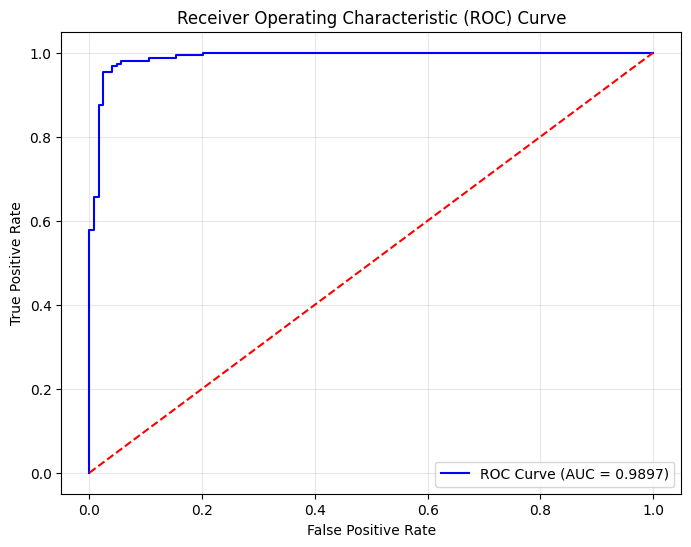

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

source_folder = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/source_folder"
test_dir = os.path.join(source_folder, "test")


IMG_SIZE = (224, 224)  # VGG19 input size
BATCH_SIZE = 32


base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)  # Extract features from block5_pool
vgg19_model.trainable = False


def load_data(directory):
    data = []
    labels = []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                data.append(img_array)
                labels.append(label)
    data = np.array(data)
    labels = np.array(labels)
    return data, labels


test_data, test_labels = load_data(test_dir)


label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)


test_features = vgg19_model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)


test_features_reshaped = test_features.reshape(test_features.shape[0], 7, 7, 512)


inception_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v3_scratch_with_vgg19_features.h5")


predicted_probs = inception_model.predict(test_features_reshaped, batch_size=BATCH_SIZE)


fpr, tpr, thresholds = roc_curve(test_labels_encoded, predicted_probs)
roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 223s 24s/step


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step
Precision: 0.9497
Recall: 0.9805
F1 Score: 0.9649
Confusion Matrix:
[[116   8]
 [  3 151]]


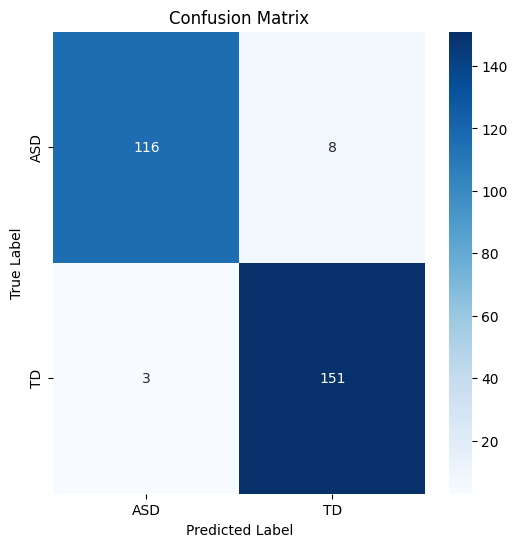

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


source_folder = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/source_folder"
test_dir = os.path.join(source_folder, "test")
model_path = "/content/drive/MyDrive/Colab_Notebooks/major_new_dataset/model_saving/inception_v3_scratch_with_vgg19_features.h5"


IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Loading VGG19 model for feature extraction
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg19_model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)
vgg19_model.trainable = False


def load_data(directory):
    data, labels = [], []
    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=IMG_SIZE)
                img_array = img_to_array(img)
                img_array = preprocess_input(img_array)
                data.append(img_array)
                labels.append(label)
    return np.array(data), np.array(labels)


test_data, test_labels = load_data(test_dir)


label_encoder = LabelEncoder()
test_labels_encoded = label_encoder.fit_transform(test_labels)


test_features = vgg19_model.predict(test_data, batch_size=BATCH_SIZE, verbose=1)


inception_model = tf.keras.models.load_model(model_path)

predicted_probs = inception_model.predict(test_features, batch_size=BATCH_SIZE)
predicted_labels = (predicted_probs > 0.5).astype(int)


precision = precision_score(test_labels_encoded, predicted_labels)
recall = recall_score(test_labels_encoded, predicted_labels)
f1 = f1_score(test_labels_encoded, predicted_labels)
conf_matrix = confusion_matrix(test_labels_encoded, predicted_labels)


print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Plotting confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
